# IMDB Dataset Vocabulary Customization for 2-Headed Transformer Encoder

In [1]:
# after installation and kernel upgrade restart needed
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import keras
import keras_nlp
import numpy as np
import tensorflow as tf
import shutil

AUTOTUNE = tf.data.AUTOTUNE
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# matplotlib settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## Data 

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

# set training and testing data paths
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [4]:
# create datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

class_labels = train_ds.class_names
print("\nClass names:", class_labels)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Class names: ['neg', 'pos']


In [5]:
# concat reviews texts from train and validation datasets discarding labels 
reviews = tf.concat(([review for review, _ in train_ds.unbatch()], 
                     [review for review, _ in val_ds.unbatch()]), axis=0)

# TextVectorization layer allows efficiently extract vocabulary from the text 
# while optionally appling standardization to it
vectorizer = tf.keras.layers.TextVectorization()
vectorizer.adapt(reviews)

# compute the number of tokens per each review
bows = vectorizer(reviews)
counts = tf.math.count_nonzero(bows, axis=1, keepdims=True)

# get a mean and standard deviation of reviews word counts 
mean, std = tf.math.reduce_mean(counts), tf.math.reduce_std(tf.cast(counts, dtype=tf.float32))
min, max = tf.reduce_min(counts), tf.reduce_max(counts)

print("Number of unique words in both train and valid datasets:", vectorizer.vocabulary_size())
print(f"Reviews contain {mean} words on average, with standard deviation of {std} words")
print(f"Minimum/maximum review word count: {min}/{max}")

Number of unique words in both train and valid datasets: 121894
Reviews contain 232 words on average, with standard deviation of 173.0606689453125 words
Minimum/maximum review word count: 10/2469


## Custom vocabulary

### Utility Functions for extracting custom vocabulary

In [6]:
def create_vocab(vocab_size, dataset, **kwargs):
    """
    Trains a WordPiece vocabulary from an input dataset
    using KerasNLP utility function compute_word_piece_vocabulary()
    Args:
    vocab_size (int) - desired size of the trained wocabulary;
    dataset (tf.data.Dataset) - dataset from which vocabulary is extracted.
    Returns:
    vocab (list): list of vocabulary terms.
    """
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        dataset.map(lambda x, y: x),
        vocabulary_size=vocab_size,
        lowercase=True,
        strip_accents=True,
        reserved_tokens=["[PAD]", "[START]", "[END]", "[MASK]", "[UNK]"],
        **kwargs,
    )
    return vocab

def create_tokenizer(vocab, **kwargs):
    """
    Creates a tokenizer based on the vocabulary passed to WordPieceTokenizer.
    Args:
    vocab (list): list of vocabulary tokens.
    Returns: 
    tokenizer (obj): Instance of WordPieceTokenizer.
    """
    tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
        vocabulary=vocab,
        lowercase=True,
        strip_accents=True,
        oov_token="[UNK]",
        **kwargs,
    )
    return tokenizer

def create_packer(tokenizer, **kwargs):
    """
    Creates a layer that adds start and end tokens to the sequence and
    pads to a fixed length using StartEndPacker and a tokenizer passed to it.
    Args:
    tokenizer (obj): Instance of WordPieceTokenizer.
    Returns:
    packer (obj): Instance of StartEndPacker layer.
    """
    packer = keras_nlp.layers.StartEndPacker(
        start_value=tokenizer.token_to_id("[START]"),
        end_value=tokenizer.token_to_id("[END]"),
        pad_value=tokenizer.token_to_id("[PAD]"),
        sequence_length=512,
        **kwargs,
    )
    return packer

def preprocess(x, y):
    """
    Preprocesses inputs by tokenizing (tokenizer) and adding start/end token and padding 
    to the predifined length (packer)
    Args:
    x (tensor), y (tensor) - input text and its label respectively.
    Returns:
    token_ids (tensor) - transformed x;
    y (tensor) - passthrough.
    """
    token_ids = packer(tokenizer(x))
    return token_ids, y

def get_prepr_dataset(dataset):
    """
    Preprocesses the dataset by mapping preprocessing function 
    Args:
    dataset (tf.data.Dataset): input text, labels tensors.
    Returns:
    (tf.data.Dataset) - transformed dataset.
    """
    return dataset.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [10]:
vocabulary = create_vocab(vocab_size=30_000, dataset=train_ds)
tokenizer = create_tokenizer(vocab=vocabulary)
packer = create_packer(tokenizer)

train_prepr = get_prepr_dataset(train_ds)
val_prepr = get_prepr_dataset(val_ds)

# preview extracted tokenized text 
print(train_prepr.unbatch().take(1).get_single_element())

(<tf.Tensor: shape=(512,), dtype=int32, numpy=
array([   1,   51,  538,   99,  159, 4036, 3283,  110,  152, 1648,   16,
         97,   51,  143,  225,  105,  161,  291,  555,  102,   18,  102,
        381,   11,   62,   96,  888,  840,  307,  210,  375,  100, 5199,
        251,  108,   96,  171,   16,   97, 2692, 2692, 2692,   18,   18,
         18,  114, 1294,   11,   62, 1188,  108,   96, 7719,  175, 2902,
        133,  108,  188,   99,  516,  170,  386,   18,  102,  106,  144,
        237,   16,  179,  114,  309,  188,  235,   96,  733,   16,  339,
        165,   96,  313,  109,  120,  135,  188,  492,  386,   18,  167,
        189,  257, 2382,   99,   96,  112,   16,  179,  102,  252,   11,
         62,  401,  130, 3037, 2525,   16,  133, 1292, 1267,   18,  102,
        106,  157,  258,   16,   97,   51,  194,  102,  106, 2128, 8160,
         11,   61,  209,  329,   18,  122,  103,  122,   18,   18,   18,
         51,  153,  496,  477,  102,    5,    2,    0,    0,    0,    0,
    

## Design a tiny transformer encoder based model 

In [15]:
def create_model(vocab):
    """
    Custom Transformer Encoder model using Functional API
    """
    # model inputs 
    token_id_input = keras.Input(shape=(None,), dtype="int32", name="token_ids",)
    # positional encoding + token encoding
    outputs = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=len(vocab),
        sequence_length=packer.sequence_length,
        embedding_dim=64)(token_id_input)
    # 2-headed transformer encoder
    outputs = keras_nlp.layers.TransformerEncoder(
        num_heads=2,
        intermediate_dim=128,
        dropout=0.1)(outputs)
    # Extract representation of the first token (not extracting directly due to error when loading saved model later)
    first_token = tf.keras.layers.Lambda(lambda x: x[:, 0, :])(outputs)
    # Classification layer
    outputs = keras.layers.Dense(2)(first_token)
    model = keras.Model(inputs=token_id_input, outputs=outputs, name="transformer_classifier")
    return model

@keras.utils.register_keras_serializable()
class TransformerClassifier(keras.Model):
    """
    Custom Transformer Encoder model using Subclassing API
    """
    def __init__(
        self, vocab_size, seq_length, embed_dim=64, n_heads=2, 
        inter_dim=128, dropout=0.1, n_classes=2, **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.tok_pos_encoding = keras_nlp.layers.TokenAndPositionEmbedding(            
            vocabulary_size=vocab_size,
            sequence_length=seq_length,
            embedding_dim=embed_dim)
        self.encoder = keras_nlp.layers.TransformerEncoder(
            num_heads=n_heads,
            intermediate_dim=inter_dim,
            dropout=dropout)
        self.outputs = keras.layers.Dense(units=n_classes)

    def call(self, inputs):
        z = self.tok_pos_encoding(inputs)
        z = self.encoder(z)
        z = self.outputs(z[:, 0, :])  # Slicing to get the representation of the first token
        return z

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "vocab_size": self.vocab_size, 
                "seq_length": self.seq_length}

    def summary(self):
        x = keras.Input(shape=(None,), dtype=tf.int32, name="token_ids")
        model = keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

# model compilation
def compile_model(model, lr_rate):
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.AdamW(lr_rate),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        jit_compile=True)

# extract performance of a model on a given dataset as a scalar value
def get_performance(model, dataset, metric="sparse_categorical_accuracy"):
    """Evaluates model on a given dataset and returns specified metric value"""
    return model.evaluate(dataset, return_dict=True, verbose=0)[metric]

In [16]:
# get model created using Functional API
model = create_model(vocabulary)
model.summary()

Model: "transformer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ token_ids (InputLayer)          │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_3  │ (None, None, 64)       │     1,342,912 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, None, 64)       │        33,472 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,376,514 (5.25 MB)

 Trainable params: 1,376,514 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# the same model, but using Subclassing API
model = TransformerClassifier(vocab_size=len(vocabulary), seq_length=packer.sequence_length)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ token_ids (InputLayer)          │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_2  │ (None, None, 64)       │     1,342,912 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, None, 64)       │        33,472 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_1 (GetItem)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,376,514 (5.25 MB)

 Trainable params: 1,376,514 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

## Train the classifier directly on the classification objective

In [14]:
# helper function to visualize model training curves
def plot_history(history):
    """
    Plots training curves given training and validation 
    (accuracy, loss) keys provided in the history.
    """
    # get keys from the dictionary 
    hist_keys = list(history.history.keys())
    # performance plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ax1.plot(history.history[hist_keys[0]])
    ax1.plot(history.history[hist_keys[2]])
    ax1.set_title('Model Loss')
    ax1.set_ylabel(hist_keys[0])
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'valid'], loc='upper left')
    ax1.grid(True)
    # loss plot
    ax2.plot(history.history[hist_keys[1]])
    ax2.plot(history.history[hist_keys[3]])
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel(hist_keys[1])
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'valid'], loc='upper right')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

# def plot compare models
def plot_stats(stats):
    """
    Given a dictionary of (model name, model performance)
    items outputs comparative plot.
    """
    mode = ("Train", "Valid")
    models = list(stats.keys())
    x = np.arange(len(models))  # the label locations
    y = np.round(np.array(list(stats.values())), 3)
    y1, y2 = y[:, 0], y[:, 1]
    width = 0.15  # the width of the bars
    plt.figure(figsize=(4, 3), layout='constrained')
    bar1 = plt.bar(x-0.1, y1, width) 
    bar2 = plt.bar(x+0.1, y2, width)
    plt.bar_label(bar1)
    plt.bar_label(bar2)
    plt.xticks(x, models)
    plt.ylim(0.8)
    plt.title("Models training/validation set performance")
    plt.legend(mode, loc='upper left', ncols=2)
    plt.grid(True)
    plt.show()

In [138]:
class TriangularScheduler(keras.optimizers.schedules.LearningRateSchedule):
    """Linear ramp up for 'warmup' steps, then linear decay to 0 at 'total steps'."""
    def __init__(self, rate, warmup, total):
        self.rate = rate
        self.warmup = warmup
        self.total = total

    def get_config(self):
        config = {"rate": self.rate, "warmup": self.warmup, "total": self.total}
        return config

    def __call__(self, step):
        step = keras.ops.cast(step, dtype="float32")
        rate = keras.ops.cast(self.rate, dtype="float32")
        warmup = keras.ops.cast(self.warmup, dtype="float32")
        total = keras.ops.cast(self.total, dtype="float32")

        warmup_rate = rate * step / self.warmup
        cooldown_rate = rate * (total - step) / (total - warmup)
        triangular_rate = keras.ops.minimum(warmup_rate, cooldown_rate)
        return keras.ops.maximum(triangular_rate, 0.0)

In [139]:
epochs = 20
batch_size = 32
steps_per_epoch = train_ds.cardinality().numpy()
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate = 5e-5

warmup_schedule = TriangularScheduler(initial_learning_rate, warmup_steps, num_train_steps)

In [36]:
# create a range of vocab sizes to explore
vocab_sizes = [5000, 10_000, 30_000, 50_000, 70_000, 100_000]

# dictionary to save models performances
performance = {}

### 5000 words

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.7548 - sparse_categorical_accuracy: 0.5054 - val_loss: 0.6884 - val_sparse_categorical_accuracy: 0.5078
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.6992 - sparse_categorical_accuracy: 0.5268 - val_loss: 0.6375 - val_sparse_categorical_accuracy: 0.6716
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.5958 - sparse_categorical_accuracy: 0.6834 - val_loss: 0.4465 - val_sparse_categorical_accuracy: 0.7840
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.4062 - sparse_categorical_accuracy: 0.8174 - val_loss: 0.3809 - val_sparse_categorical_accuracy: 0.8254
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.3377 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.3332 - val_sparse_categorical_accuracy: 0.8626
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.3077 - sparse_categorical_accuracy: 0.8752 - val_loss: 0.3046 - val_sparse_categorical_accuracy:

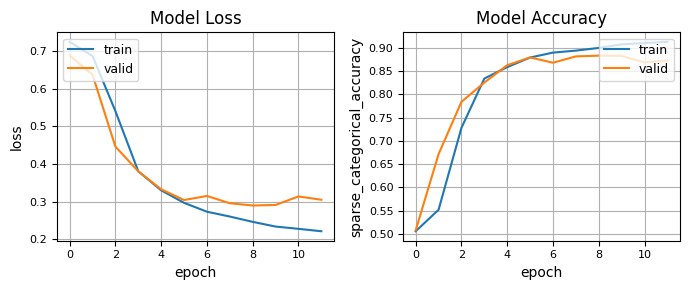

5000-vocabulary model performance on the validation set: 0.8831999897956848


In [141]:
# data tokenization & packing
vocabulary = create_vocab(vocab_size=vocab_sizes[0], dataset=train_ds)
tokenizer = create_tokenizer(vocab=vocabulary)
packer = create_packer(tokenizer)
# get preprocessed training and validation data using new vocabulary 
train_prepr = get_prepr_dataset(train_ds)
val_prepr = get_prepr_dataset(val_ds)

# set up model and compile it
model = create_model(vocabulary)
compile_model(model, lr_rate=warmup_schedule)
# train the model using triangular scheduling
e_stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    train_prepr, validation_data=val_prepr, epochs=epochs, callbacks=[e_stop]
)

plot_history(history)
# get performance on training/validation sets to compare later 
performance[vocab_sizes[0]] = (get_performance(model, train_prepr), get_performance(model, val_prepr))
print(f"{vocab_sizes[0]}-vocabulary model performance on the validation set: {performance[vocab_sizes[0]][1]}")
# save model 
model.save(f"{vocab_sizes[0]}-T.keras")

### 10000 words

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.7641 - sparse_categorical_accuracy: 0.5077 - val_loss: 0.6922 - val_sparse_categorical_accuracy: 0.5076
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.7037 - sparse_categorical_accuracy: 0.5166 - val_loss: 0.6479 - val_sparse_categorical_accuracy: 0.6620
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6048 - sparse_categorical_accuracy: 0.6664 - val_loss: 0.4091 - val_sparse_categorical_accuracy: 0.8228
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.3893 - sparse_categorical_accuracy: 0.8291 - val_loss: 0.3268 - val_sparse_categorical_accuracy: 0.8666
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.3266 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.3399 - val_sparse_categorical_accuracy: 0.8558
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.2754 - sparse_categorical_accuracy: 0.8847 - val_loss: 0.3293 - val_sparse_categorical_accuracy:

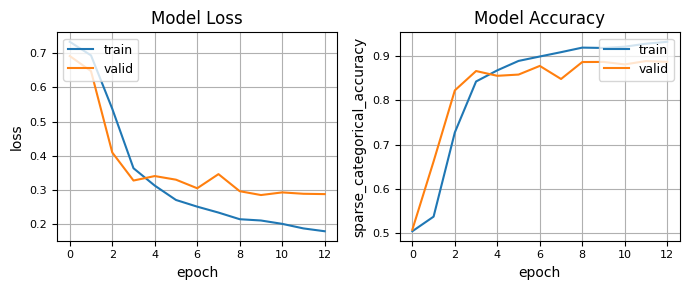

10000-vocabulary model performance on the validation set: 0.8871999979019165


In [144]:
# data tokenization & packing
vocabulary = create_vocab(vocab_size=vocab_sizes[1], dataset=train_ds)
tokenizer = create_tokenizer(vocab=vocabulary)
packer = create_packer(tokenizer)
# get preprocessed training and validation data using new vocabulary 
train_prepr = get_prepr_dataset(train_ds)
val_prepr = get_prepr_dataset(val_ds)

# set up model and compile it
model = create_model(vocabulary)
compile_model(model, lr_rate=warmup_schedule)
# train the model using triangular scheduling
e_stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    train_prepr, validation_data=val_prepr, epochs=epochs, callbacks=[e_stop]
)

plot_history(history)
# get performance on training/validation sets to compare later 
performance[vocab_sizes[1]] = (get_performance(model, train_prepr), get_performance(model, val_prepr))
print(f"{vocab_sizes[1]}-vocabulary model performance on the validation set: {performance[vocab_sizes[1]][1]}")
model.save(f"{vocab_sizes[1]}-T.keras")

### 30000 words

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.7459 - sparse_categorical_accuracy: 0.5074 - val_loss: 0.6893 - val_sparse_categorical_accuracy: 0.5076
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6953 - sparse_categorical_accuracy: 0.5346 - val_loss: 0.6241 - val_sparse_categorical_accuracy: 0.6770
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.5725 - sparse_categorical_accuracy: 0.6993 - val_loss: 0.5159 - val_sparse_categorical_accuracy: 0.7270
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.3637 - sparse_categorical_accuracy: 0.8440 - val_loss: 0.4405 - val_sparse_categorical_accuracy: 0.7932
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.3010 - sparse_categorical_accuracy: 0.8777 - val_loss: 0.3309 - val_sparse_categorical_accuracy: 0.8580
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.2623 - sparse_categorical_accuracy: 0.8926 - val_loss: 0.2969 - val_sparse_categorical_accuracy:

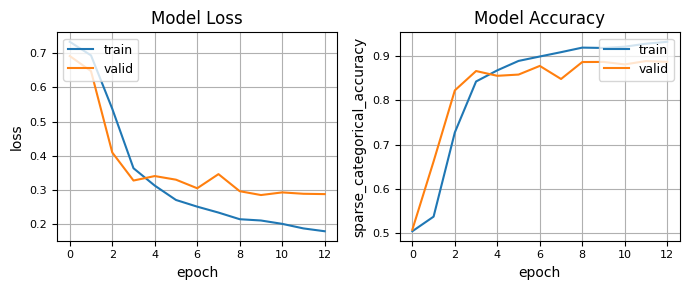

30000-vocabulary model performance on the validation set: 0.8924000263214111


In [147]:
# data tokenization & packing
vocabulary = create_vocab(vocab_size=vocab_sizes[2], dataset=train_ds)
tokenizer = create_tokenizer(vocab=vocabulary)
packer = create_packer(tokenizer)
# get preprocessed training and validation data using new vocabulary 
train_prepr = get_prepr_dataset(train_ds)
val_prepr = get_prepr_dataset(val_ds)

# set up model and compile it
model = create_model(vocabulary)
compile_model(model, lr_rate=warmup_schedule)
# train the model using triangular scheduling
e_stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model.fit(
    train_prepr, validation_data=val_prepr, epochs=epochs, callbacks=[e_stop],
)

plot_history(history)
# get performance on training/validation sets to compare later 
performance[vocab_sizes[2]] = (get_performance(model, train_prepr), get_performance(model, val_prepr))
print(f"{vocab_sizes[2]}-vocabulary model performance on the validation set: {performance[vocab_sizes[2]][1]}")
model.save(f"{vocab_sizes[2]}-T.keras")

### 50000 words

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.9399 - sparse_categorical_accuracy: 0.4935 - val_loss: 0.6904 - val_sparse_categorical_accuracy: 0.5076
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.7011 - sparse_categorical_accuracy: 0.5162 - val_loss: 0.6666 - val_sparse_categorical_accuracy: 0.5654
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.6202 - sparse_categorical_accuracy: 0.6505 - val_loss: 0.4387 - val_sparse_categorical_accuracy: 0.8140
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3990 - sparse_categorical_accuracy: 0.8242 - val_loss: 0.3376 - val_sparse_categorical_accuracy: 0.8546
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.3040 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.3907 - val_sparse_categorical_accuracy: 0.8242
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.2619 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.2797 - val_sparse_categorical_accuracy: 0.88

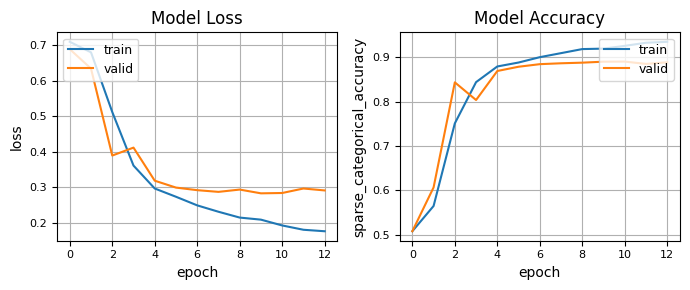

50000-vocabulary model performance on the validation set: 0.890999972820282


In [47]:
# data tokenization & packing
vocabulary = create_vocab(vocab_size=vocab_sizes[3], dataset=train_ds)
tokenizer = create_tokenizer(vocab=vocabulary)
packer = create_packer(tokenizer)
# get preprocessed training and validation data using new vocabulary 
train_prepr = get_prepr_dataset(train_ds)
val_prepr = get_prepr_dataset(val_ds)

# set up model and compile it
model = create_model(vocabulary)
compile_model(model, lr_rate=warmup_schedule)
# train the model using triangular scheduling
e_stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model.fit(
    train_prepr, validation_data=val_prepr, epochs=epochs, callbacks=[e_stop],
)

plot_history(history)
# get performance on training/validation sets to compare later 
performance[vocab_sizes[3]] = (get_performance(model, train_prepr), get_performance(model, val_prepr))
print(f"{vocab_sizes[3]}-vocabulary model performance on the validation set: {performance[vocab_sizes[3]][1]}")
model.save(f"{vocab_sizes[3]}-T.keras")

### 70000 words

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.7653 - sparse_categorical_accuracy: 0.5070 - val_loss: 0.6892 - val_sparse_categorical_accuracy: 0.5076
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6998 - sparse_categorical_accuracy: 0.5236 - val_loss: 0.6341 - val_sparse_categorical_accuracy: 0.6182
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.5862 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.3813 - val_sparse_categorical_accuracy: 0.8448
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3783 - sparse_categorical_accuracy: 0.8362 - val_loss: 0.3654 - val_sparse_categorical_accuracy: 0.8376
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3009 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.2964 - val_sparse_categorical_accuracy: 0.8834
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.2622 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.2971 - val_sparse_categorical_accuracy: 0.87

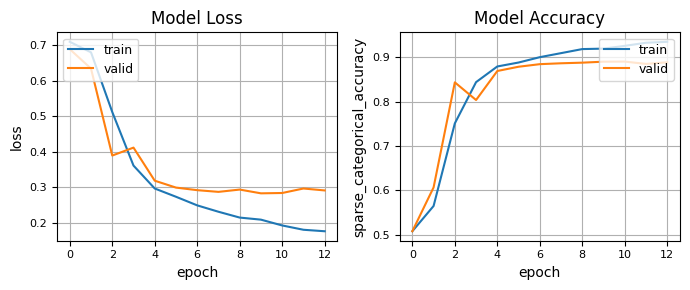

70000-vocabulary model performance on the validation set: 0.8935999870300293


In [49]:
# data tokenization & packing
vocabulary = create_vocab(vocab_size=vocab_sizes[4], dataset=train_ds)
tokenizer = create_tokenizer(vocab=vocabulary)
packer = create_packer(tokenizer)
# get preprocessed training and validation data using new vocabulary 
train_prepr = get_prepr_dataset(train_ds)
val_prepr = get_prepr_dataset(val_ds)

# set up model and compile it
model = create_model(vocabulary)
compile_model(model, lr_rate=warmup_schedule)
# train the model using triangular scheduling
e_stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model.fit(
    train_prepr, validation_data=val_prepr, epochs=epochs, callbacks=[e_stop],
)

plot_history(history)
# get performance on training/validation sets to compare later 
performance[vocab_sizes[4]] = (get_performance(model, train_prepr), get_performance(model, val_prepr))
print(f"{vocab_sizes[4]}-vocabulary model performance on the validation set: {performance[vocab_sizes[4]][1]}")
model.save(f"{vocab_sizes[4]}-T.keras")

### 100000 words

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 1.0040 - sparse_categorical_accuracy: 0.4955 - val_loss: 0.6892 - val_sparse_categorical_accuracy: 0.5496
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6988 - sparse_categorical_accuracy: 0.5179 - val_loss: 0.6530 - val_sparse_categorical_accuracy: 0.6890
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6139 - sparse_categorical_accuracy: 0.6657 - val_loss: 0.4993 - val_sparse_categorical_accuracy: 0.7340
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.4000 - sparse_categorical_accuracy: 0.8161 - val_loss: 0.3625 - val_sparse_categorical_accuracy: 0.8398
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.8753 - val_loss: 0.2984 - val_sparse_categorical_accuracy: 0.8826
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.2546 - sparse_categorical_accuracy: 0.8986 - val_loss: 0.2864 - val_sparse_categorical_accuracy: 0.88

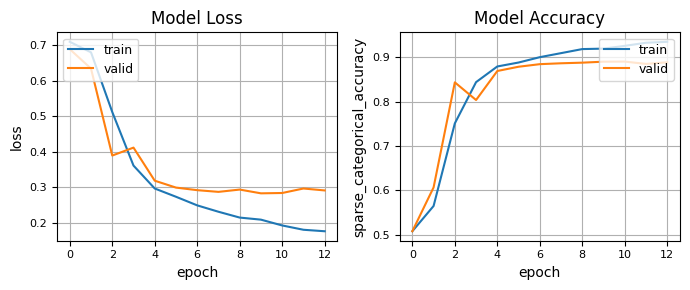

100000-vocabulary model performance on the validation set: 0.8938000202178955


In [51]:
# data tokenization & packing
vocabulary = create_vocab(vocab_size=vocab_sizes[5], dataset=train_ds)
tokenizer = create_tokenizer(vocab=vocabulary)
packer = create_packer(tokenizer)
# get preprocessed training and validation data using new vocabulary 
train_prepr = get_prepr_dataset(train_ds)
val_prepr = get_prepr_dataset(val_ds)

# set up model and compile it
model = create_model(vocabulary)
compile_model(model, lr_rate=warmup_schedule)
# train the model using triangular scheduling
e_stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model.fit(
    train_prepr, validation_data=val_prepr, epochs=epochs, callbacks=[e_stop],
)

plot_history(history)
# get performance on training/validation sets to compare later 
performance[vocab_sizes[5]] = (get_performance(model, train_prepr), get_performance(model, val_prepr))
print(f"{vocab_sizes[5]}-vocabulary model performance on the validation set: {performance[vocab_sizes[5]][1]}")
model.save(f"{vocab_sizes[5]}-T.keras")

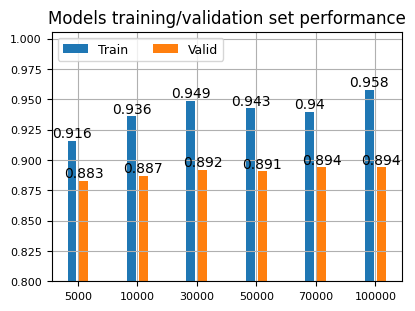

In [148]:
plot_stats(performance)

In [149]:
# get 30000 vocab data
vocabulary = create_vocab(vocab_size=vocab_sizes[2], dataset=train_ds)
tokenizer = create_tokenizer(vocab=vocabulary)
packer = create_packer(tokenizer)
# get preprocessed training and validation data using new vocabulary 
test_prepr = get_prepr_dataset(test_ds)

model = keras.models.load_model(f"{vocab_sizes[2]}-T.keras", compile=False, safe_mode=False)
compile_model(model, warmup_schedule)
model.evaluate(test_prepr)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3013 - sparse_categorical_accuracy: 0.8813


[0.30146294832229614, 0.8803600072860718]